In [1]:
from scipy.io import loadmat
import numpy as np
import os
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt

In [2]:
# Indexer
class Subjects:
    class Sessions:
        class Runs:

            def __init__(self, paths) -> None:
                self.paths = sorted(paths, key= lambda x: int(x.split('_')[-1][3]))

            def __getitem__(self, run_idx):
                return self.load_data(self.paths[run_idx])
            
            def load_data(self, path):
                mat_contents = loadmat(path, struct_as_record=False, squeeze_me=True)
                return mat_contents["p"].__dict__

        def __init__(self, path) -> None:
            self.base_path = os.path.join(path, "runs")
            self.sess_paths = sorted(os.listdir(self.base_path), key= lambda x: int(x.split('_')[2][1]))
            self.sess_paths = [os.path.join(self.base_path, path) for path in self.sess_paths]
            self.sess_paths = [self.sess_paths[i:i+6] for i in range(0, len(self.sess_paths), 6)]

        def __getitem__(self, sess_idx):
            return self.Runs(self.sess_paths[sess_idx])

    def __init__(self, path) -> None:
        self.path = path
        self.subj_paths = sorted(os.listdir(path), key=lambda x: int(x.split('j')[1]))

    def __getitem__(self, sub_idx):
        return self.Sessions(os.path.join(self.path, self.subj_paths[sub_idx]))

# Refresher
def np_refresh(np_array): return np.array(np_array.tolist()).astype("float")

In [3]:
# Set in stone
PATH_DS = '../axej_eeg'
EXP_ORI = [159, 123, 87, 51, 15]
SUBS = 13
SESS = 4
RUNS = 6

subj = Subjects(PATH_DS)

# Index combinations at 3 levels with ittertools
data_idx = list(itertools.product(range(SUBS), range(SESS), range(RUNS)))

In [4]:
# Expectation
# pcat.tr_exp = pcat.trlabel(pcat.prior == 1);
# pcat.tr_un = pcat.trlabel(pcat.prior == 3);
# pcat.tr_neu = pcat.trlabel(pcat.prior == 2);

# Attention = attCue
# pcat.tr_foc = pcat.trlabel(pcat.attcue == 1); = attCue
# pcat.tr_div = pcat.trlabel(pcat.attcue == 2); = attCue
# div -> -1, for -> 1

# Coherence = tgCoh
# pcat.tr_lo = pcat.trlabel(pcat.moco == 1); = tgCoh
# pcat.tr_hi = pcat.trlabel(pcat.moco == 2); = tgCoh
# low -> -1, high -> 1

# Observation = response_angle

# Target = stimDirREAL
# Coherece oriantation = EXP_ORI[p.expOri]
# Coherence strength = tgCoh
# Attention state = attCue
# bias = np.ones

In [5]:
data = subj[0][0][0]


In [6]:
data.keys()

dict_keys(['_fieldnames', 'exptName', 'subName', 'sessionNum', 'runNum', 'rndSeed', 'EEG', 'ori', 'alloriTag', 'tgCoh', 'attCue', 'cueColor', 'tgColor', 'expOri', 'unexpOri', 'stimDir', 'stimDirReal', 'stimDirREAL', 'tnumb', 'fdur', 'joyx', 'joyy', 'f_precuedur', 'f_cuedur', 'f_tgdur', 'f_nontgdur', 'f_ITIdur', 'stimonset', 'cueonset', 'SCI', 'tgonset', 'CTI', 'tgoffset', 'tgDur', 'stimoffset', 'stimDur', 'ITI'])

In [ ]:
data

In [15]:
data["timeeachframe"].shape

(120, 500)

In [17]:
data["fdur"].shape

(120, 500)

In [24]:
for idx in range(120):
    tot = 0
    for time in data["timeeachframe"][idx]:
        tot += time if time > 0 else 0

print(tot)

655.0771897409577


In [8]:
shape = (SESS, RUNS - 1)

jx = np.ndarray(shape=shape, dtype=object)
jy = np.ndarray(shape=shape, dtype=object)
sti_dir = np.ndarray(shape=shape, dtype=object)
ori_dir = np.ndarray(shape=shape, dtype=object)
ori_st = np.ndarray(shape=shape, dtype=object)
att_st = np.ndarray(shape=shape, dtype=object)

subs = 5
for sess, runs in itertools.product(range(SESS), range(RUNS)):
    if runs == 5: continue
    data = subj[subs][sess][runs]
    jx[sess, runs] = data['joyx']
    jy[sess, runs] = data['joyy']
    sti_dir[sess, runs] = data['stimDirREAL']
    ori_dir[sess, runs] = EXP_ORI[data['expOri'] - 1]
    ori_st[sess, runs] = data['tgCoh']
    att_st[sess, runs] = data['attCue']

jx = np_refresh(jx)
jy = np_refresh(jy)
sti_dir = np_refresh(sti_dir)
ori_dir = np_refresh(ori_dir)
ori_st = np_refresh(ori_st)
att_st = np_refresh(att_st)

# Repeat ori for each trial
ori_dir = np.expand_dims(ori_dir, axis=2)
ori_dir = np.repeat(ori_dir, 120, axis=2)

jx.shape, jy.shape

((4, 5, 120, 500), (4, 5, 120, 500))

In [125]:
sti_dir.shape, ori_dir.shape, ori_st.shape, att_st.shape

((4, 5, 120), (4, 5, 120), (4, 5, 120), (4, 5, 120))

In [126]:
def make_responses(jx, jy):
    dist_from_cent = np.sqrt(jx ** 2 + jy ** 2)
    dist_from_cent[np.isnan(dist_from_cent)] = 0
    max_idx = np.argmax(dist_from_cent, axis=3)

    max_x = jx[np.arange(4)[:, np.newaxis, np.newaxis], np.arange(5)[:, np.newaxis], np.arange(120), max_idx]
    max_y = jy[np.arange(4)[:, np.newaxis, np.newaxis], np.arange(5)[:, np.newaxis], np.arange(120), max_idx]

    resp_angle = np.arctan2(max_y, max_x)
    resp_angle = np.rad2deg(resp_angle)

    return resp_angle, max_idx

In [127]:
resp_angle, resp_idx = make_responses(jx, jy)
resp_angle.shape, resp_idx.shape

((4, 5, 120), (4, 5, 120))

In [130]:
# replace all 2 with -1 for input_att_st
att_st[att_st == 2] = -1.0

ori_st[ori_st == 1] = -1.0
ori_st[ori_st == 2] = 1.0

In [131]:
resp_angle.shape, sti_dir.shape, ori_dir.shape, ori_st.shape, att_st.shape

((4, 5, 120), (4, 5, 120), (4, 5, 120), (4, 5, 120), (4, 5, 120))

In [132]:
import pandas as pd

df = pd.DataFrame({
    'resp_angle': resp_angle.flatten()/180,
    'sti_dir': sti_dir.flatten()/ 180,
    'ori_dir': ori_dir.flatten()/ 180,
    'ori_st': ori_st.flatten(),
    'att_st': att_st.flatten(),
})

In [133]:
# correct = resp_angle / sti_dir if resp_angle < sti_dir or else sti_dir / resp_angle
df["err"] = df["resp_angle"] - df["sti_dir"]
# make all errs positive
df["err"] = df["err"].abs()

In [135]:
df

,resp_angle,sti_dir,ori_dir,ori_st,att_st,err
0,0.342095,0.083333,0.883333,-1.0,-1.0,0.258761
1,0.840422,0.883333,0.883333,-1.0,-1.0,0.042912
2,0.176434,0.883333,0.883333,1.0,1.0,0.706899
3,0.610951,0.683333,0.883333,1.0,-1.0,0.072382
4,0.168584,0.883333,0.883333,-1.0,1.0,0.714749
...,...,...,...,...,...,...
2395,0.150625,0.083333,0.083333,-1.0,1.0,0.067291
2396,0.152134,0.083333,0.083333,1.0,-1.0,0.068801
2397,0.146563,0.083333,0.083333,1.0,1.0,0.063230
2398,0.156618,0.083333,0.083333,-1.0,-1.0,0.073285


<Axes: >

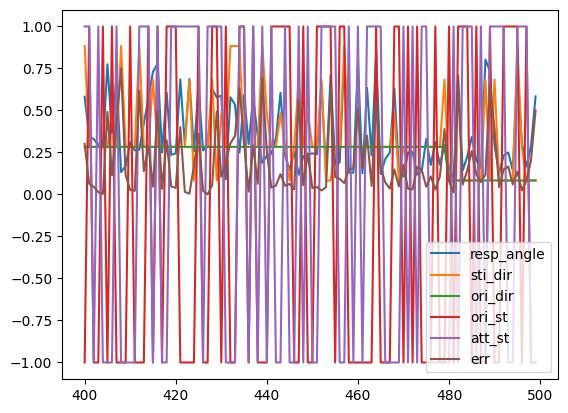

In [144]:
idx = 400
df[idx:idx+100].plot()

In [138]:
# group by attention state and average error

df.groupby("att_st").mean()["err"]

att_st
-1.0    0.188287
 1.0    0.183581
Name: err, dtype: float64

In [140]:
[ x * 180 for x in [0.188287, 0.183581]]

[33.89166, 33.044579999999996]